In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import numpy as np
import pandas as pd

from nlp_surveillance.event_db_preprocessing import event_db


In [ ]:
event_db = pd.read_csv('data/rki/edb.csv', sep=';')

In [ ]:
event_db.columns = list(map(lambda x: x.strip(), event_db))

In [ ]:
event_db

In [4]:
edb = event_db._read_unprocessed()
cleaned_edb = event_db.read_cleaned()

# URL clustering

In [101]:
from urllib.parse import urlparse
from collections import defaultdict
from operator import itemgetter

urls = cleaned_edb.URL
netlocs = [urlparse(url).netloc for url in urls]
d = defaultdict(int)
for n in netloc:
    d[n] = d[n] + 1
netloc_occurence_tuples = list(d.items())

In [108]:
sorted_netloc_occurence_tuples = sorted(netloc_occurence_tuples, key=itemgetter(1))

In [109]:
most_used_netlocs = sorted_netloc_occurence_tuples[-9:]

In [110]:
most_used_netlocs

[('ecdc.europa.eu', 6),
 ('polioeradication.org', 6),
 ('www.euro.who.int', 6),
 ('www.who.int', 22),
 ('www.cidrap.umn.edu', 30),
 ('outbreaknewstoday.com', 50),
 ('apps.who.int', 74),
 (b'', 87),
 ('www.promedmail.org', 163)]

In [111]:
most_used_netlocs.remove((b'', 87))

/home/auss/miniconda3/envs/rki/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


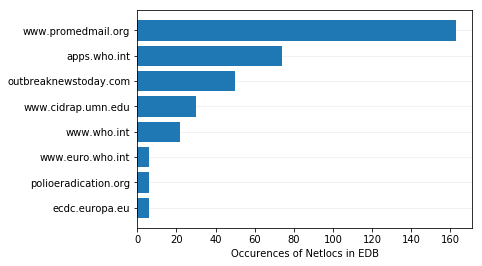

In [115]:
x = np.arange(len(most_used_netlocs))
plt.barh(x, width=[t[1] for t in most_used_netlocs]) 
plt.xlabel('Occurences of Netlocs in EDB', fontname='Times New Roman')
plt.yticks(x, [t[0] for t in most_used_netlocs])
plt.grid(which='both', axis='y', alpha=0.2)
plt.rc('axes', axisbelow=True)

# Cleaning Statistics
## Date

In [ ]:
ts = edb['Datenstand für Fallzahlen gesamt*'].replace(['nan', '-', np.nan], [None] * 3).tolist()
valid_ts = list(filter(lambda x: isinstance(x, str), ts))

In [ ]:
print('There are', len(cleaned_edb), 'entries in the cleaned event db')
print(len(valid_ts), 'of them are non-empty dates.')

In [ ]:
is_date = lambda x: re.match(r"(\d{1,2})\D(\d{1,2})\D(\d{4})", x)
valid_dates = list(filter(lambda x: is_date(x), valid_ts))
print(len(valid_dates), 'of all entries are valid dates.')

In [ ]:
print('The following are non-valid dates:')
print(list(filter(lambda x: not is_date(x), valid_ts)))

## Count

In [ ]:
print('There are', len(cleaned_edb), 'entries in the cleaned event db')
print(sum(cleaned_edb['count_edb'].notna()), 'of them are non-empty case numbers')

In [ ]:
valid_counts = edb['Fälle gesamt*'][edb['Fälle gesamt*'].notna()]

In [ ]:
def is_int(string):
    try:
        num = int(string)
    except ValueError:
        return False
    return True

In [ ]:
print('These are the invalid count entries:')
print(list(filter(lambda x: not is_int(x), valid_counts)))

## Country

In [ ]:
before = set(edb['Ausgangs- bzw. Ausbruchsland'])
after = set(cleaned_edb.country_edb)
print(before - after)
print('\n is cleaned to: \n')
print(after - before)

In [ ]:
# Stripped strings don't appear in the last set but were processed correctly
('Peru' in after) & ('Saudi-Arabien' in after) & ('Oman' in after) & ('Äthiopien' in after)

## Disease

In [ ]:
before_disease =  set(edb['Krankheitsbild(er)'])
after_disease = set(cleaned_edb['disease_edb'])
before_disease - after_disease 

## URLs

In [ ]:
before_URLs =  set(edb['Link zur Quelle 1'])
after_URLs = set(cleaned_edb['URL'])

In [ ]:
# Guillements, splitting by comma, additional whitespace, and non-valid URLS
# are the problem
before_URLs - after_URLs

# Annotation

In [ ]:
from nltk import sent_tokenize
from epitator.annotator import AnnoDoc
from epitator.count_annotator import CountAnnotator
from epitator.date_annotator import DateAnnotator

from utils.my_utils import flatten_list

example_text = 'Health |‘We’re Out of Options’: Doctors Battle Drug-Resistant Typhoid OutbreakSupported by‘We’re Out of Options’: Doctors Battle Drug-Resistant Typhoid OutbreakImageA baby believed to have contracted a drug-resistant strain of typhoid, hospitalized in Hyderabad, Pakistan in February.CreditCreditNadeem Khawer/European Pressphoto AgencyBy Emily BaumgaertnerApril 13, 2018The first known epidemic of extensively drug-resistant typhoid is spreading through Pakistan, infecting at least 850 people in 14 districts since 2016, according to the National Institute of Health Islamabad.The typhoid strain, resistant to five types of antibiotics, is expected to disseminate globally, replacing weaker strains where they are endemic. Experts have identified only one remaining oral antibiotic — azithromycin — to combat it; one more genetic mutation could make typhoid untreatable in some areas.Researchers consider the epidemic an international clarion call for comprehensive prevention efforts. If vaccination campaigns and modern sanitation systems don’t outpace the pathogen, they anticipate a return to the pre-antibiotic era when mortality rates soared.“This isn’t just about typhoid,” said Dr. Rumina Hasan, a pathology professor at the Aga Khan University in Pakistan. “Antibiotic resistance is a threat to all of modern medicine — and the scary part is, we’re out of options.”Typhoid fever, caused by the Salmonella Typhi bacteria, is a highly infectious disease transmitted by contaminated food or water. It causes high fevers, headaches and vomiting. About 21 million people suffer from typhoid each year, and about 161,000 die, according to the World Health Organization.Typhoid is endemic to Pakistan, where poor infrastructure, low vaccination rates and overpopulated city dwellings persist. Doctors in the Sindh province were not surprised by an outbreak in November 2016 — until cases proved unresponsive to ceftriaxone, used to treat multidrug-resistant, or MDR, strains of typhoid.Only four isolated cases of extensively drug-resistant, or XDR, typhoid had previously been reported worldwide, according to Dr. Elizabeth Klemm, an infectious disease geneticist at the Wellcome Sanger Institute in England.The outbreak’s origins were clear: Early case mapping revealed large clusters of victims around sewage lines in the city of Hyderabad. Dr. Hasan’s colleagues visited the region and found water sources that could be contaminated by leaking sewage pipes.Four deaths have been reported so far, according to the National Institute of Health Islamabad. At least one travel-related case has been detected in the United Kingdom.Genetic sequencing revealed that a common, aggressive MDR typhoid strain called H58 interacted with another bacteria, likely E. coli, and acquired from it an additional DNA molecule, called a plasmid, that coded for resistance to ceftriaxone.ImageLining up for clean water in Lahore last month. Facing a typhoid strain that resists so many types of antibiotics, public health officials are reemphasizing preventative measures, such as vaccination, boiling drinking water and hygiene.CreditK.M. Chaudary/Associated PressThe findings were disturbingly simple: XDR strains can materialize in one single step, virtually anywhere where the H58 strain and the added plasmid are both present — whether a sewer system or even a single human gut.“There are multiple worst-case scenarios,” said Dr. Klemm. “One is that this strain spreads to other regions through migration. But the other is that it pops up elsewhere on its own — plasmids with drug resistance are everywhere.”But the accumulation of resistance genes in the Sindh strain was hardly an ambush, according to a commentary by vaccine experts at the University of Maryland School of Medicine.The 1948 discovery of antibiotic treatment for typhoid plunged the infection’s fatality rate from almost one in four to just one in 100, triggering “an epic thrust-and-parry duel” between powerful drugs and “a wily bacterial foe’s stepwise acquisition of resistance to them,” wrote Dr. Myron M. Levine and Dr. Raphael Simon.Doctors still prescribe an estimated 50 million doses of antibiotics for typhoid globally each year. In Karachi, the capital of Sindh province, antibiotic resistance is increasing by 30 percent each year, according to the W.H.O.; at that rate, all typhoid cases in the city will be resistant to multiple drugs by 2020.Physicians are treating the Sindh strain with azithromycin and other more expensive treatments that must be administered in hospital settings.“Once we aren’t able to treat this effectively, we’re going back to the pre-antibiotic era. That would mean a lot of fatalities in our future,” Dr. Klemm said.To preserve the last line of defense, public health officials have launched a campaign to vaccinate 250,000 children in Hyderabad using a new typhoid conjugate vaccine, Typbar-TCV, recently prequalified by the W.H.O. The vaccine lasts at least five years and can be given to children as young as six months old, according to the W.H.O.Experts are also reinforcing hygiene habits for prevention: washing hands frequently, boiling drinking water and eating well-cooked foods. In the longer term, modern sanitation infrastructure is needed.The vaccination campaign has faced local opposition, according to local news reports, amid rumors that the vaccines have been poisoned in a Western effort to harm children. Similar suspicions have persisted since 2011, when a posed hepatitis B campaign helped gather intelligence before the Abbottabad raid that killed Osama bin Laden. Two polio vaccination workers were killed in Pakistan this January.GAVI, The Vaccine Alliance, a public–private global health partnership working to increase access to immunization, has pledged $85 million to ensure that typhoid vaccines reach developing countries.“It’s a global concern at this point,” said Dr. Eric Mintz, an epidemiologist at the Centers for Disease Control and Prevention. “Everything suggests this strain will survive well and spread easily — and acquiring resistance to azithromycin is only a matter of time.”A version of this article appears in print on , on Page D3 of the New York edition with the headline: Doctors Fight Drug-Resistant Typhoid Outbreak. Order Reprints | Today’s Paper | SubscribeRelated Coverage'
text_wise = AnnoDoc(example_text).add_tiers(CountAnnotator()).tiers['counts'].spans
sent_wise = [AnnoDoc(sent).add_tiers(CountAnnotator()).tiers['counts'].spans for sent in sent_tokenize(example_text)]
print('Count:')
print(text_wise,'\n')
print(len(text_wise), 'found entities \n')
print(flatten_list(sent_wise),'\n')
print(len(flatten_list(sent_wise)), 'found entities\n')
print('################################################################\n')
print('Date:')
example_text = 'Health |‘We’re Out of Options’: Doctors Battle Drug-Resistant Typhoid OutbreakSupported by‘We’re Out of Options’: Doctors Battle Drug-Resistant Typhoid OutbreakImageA baby believed to have contracted a drug-resistant strain of typhoid, hospitalized in Hyderabad, Pakistan in February.CreditCreditNadeem Khawer/European Pressphoto AgencyBy Emily BaumgaertnerApril 13, 2018The first known epidemic of extensively drug-resistant typhoid is spreading through Pakistan, infecting at least 850 people in 14 districts since 2016, according to the National Institute of Health Islamabad.The typhoid strain, resistant to five types of antibiotics, is expected to disseminate globally, replacing weaker strains where they are endemic. Experts have identified only one remaining oral antibiotic — azithromycin — to combat it; one more genetic mutation could make typhoid untreatable in some areas.Researchers consider the epidemic an international clarion call for comprehensive prevention efforts. If vaccination campaigns and modern sanitation systems don’t outpace the pathogen, they anticipate a return to the pre-antibiotic era when mortality rates soared.“This isn’t just about typhoid,” said Dr. Rumina Hasan, a pathology professor at the Aga Khan University in Pakistan. “Antibiotic resistance is a threat to all of modern medicine — and the scary part is, we’re out of options.”Typhoid fever, caused by the Salmonella Typhi bacteria, is a highly infectious disease transmitted by contaminated food or water. It causes high fevers, headaches and vomiting. About 21 million people suffer from typhoid each year, and about 161,000 die, according to the World Health Organization.Typhoid is endemic to Pakistan, where poor infrastructure, low vaccination rates and overpopulated city dwellings persist. Doctors in the Sindh province were not surprised by an outbreak in November 2016 — until cases proved unresponsive to ceftriaxone, used to treat multidrug-resistant, or MDR, strains of typhoid.Only four isolated cases of extensively drug-resistant, or XDR, typhoid had previously been reported worldwide, according to Dr. Elizabeth Klemm, an infectious disease geneticist at the Wellcome Sanger Institute in England.The outbreak’s origins were clear: Early case mapping revealed large clusters of victims around sewage lines in the city of Hyderabad. Dr. Hasan’s colleagues visited the region and found water sources that could be contaminated by leaking sewage pipes.Four deaths have been reported so far, according to the National Institute of Health Islamabad. At least one travel-related case has been detected in the United Kingdom.Genetic sequencing revealed that a common, aggressive MDR typhoid strain called H58 interacted with another bacteria, likely E. coli, and acquired from it an additional DNA molecule, called a plasmid, that coded for resistance to ceftriaxone.ImageLining up for clean water in Lahore last month. Facing a typhoid strain that resists so many types of antibiotics, public health officials are reemphasizing preventative measures, such as vaccination, boiling drinking water and hygiene.CreditK.M. Chaudary/Associated PressThe findings were disturbingly simple: XDR strains can materialize in one single step, virtually anywhere where the H58 strain and the added plasmid are both present — whether a sewer system or even a single human gut.“There are multiple worst-case scenarios,” said Dr. Klemm. “One is that this strain spreads to other regions through migration. But the other is that it pops up elsewhere on its own — plasmids with drug resistance are everywhere.”But the accumulation of resistance genes in the Sindh strain was hardly an ambush, according to a commentary by vaccine experts at the University of Maryland School of Medicine.The 1948 discovery of antibiotic treatment for typhoid plunged the infection’s fatality rate from almost one in four to just one in 100, triggering “an epic thrust-and-parry duel” between powerful drugs and “a wily bacterial foe’s stepwise acquisition of resistance to them,” wrote Dr. Myron M. Levine and Dr. Raphael Simon.Doctors still prescribe an estimated 50 million doses of antibiotics for typhoid globally each year. In Karachi, the capital of Sindh province, antibiotic resistance is increasing by 30 percent each year, according to the W.H.O.; at that rate, all typhoid cases in the city will be resistant to multiple drugs by 2020.Physicians are treating the Sindh strain with azithromycin and other more expensive treatments that must be administered in hospital settings.“Once we aren’t able to treat this effectively, we’re going back to the pre-antibiotic era. That would mean a lot of fatalities in our future,” Dr. Klemm said.To preserve the last line of defense, public health officials have launched a campaign to vaccinate 250,000 children in Hyderabad using a new typhoid conjugate vaccine, Typbar-TCV, recently prequalified by the W.H.O. The vaccine lasts at least five years and can be given to children as young as six months old, according to the W.H.O.Experts are also reinforcing hygiene habits for prevention: washing hands frequently, boiling drinking water and eating well-cooked foods. In the longer term, modern sanitation infrastructure is needed.The vaccination campaign has faced local opposition, according to local news reports, amid rumors that the vaccines have been poisoned in a Western effort to harm children. Similar suspicions have persisted since 2011, when a posed hepatitis B campaign helped gather intelligence before the Abbottabad raid that killed Osama bin Laden. Two polio vaccination workers were killed in Pakistan this January.GAVI, The Vaccine Alliance, a public–private global health partnership working to increase access to immunization, has pledged $85 million to ensure that typhoid vaccines reach developing countries.“It’s a global concern at this point,” said Dr. Eric Mintz, an epidemiologist at the Centers for Disease Control and Prevention. “Everything suggests this strain will survive well and spread easily — and acquiring resistance to azithromycin is only a matter of time.”A version of this article appears in print on , on Page D3 of the New York edition with the headline: Doctors Fight Drug-Resistant Typhoid Outbreak. Order Reprints | Today’s Paper | SubscribeRelated Coverage'
text_wise = AnnoDoc(example_text).add_tiers(DateAnnotator()).tiers['dates'].spans
sent_wise = [AnnoDoc(sent).add_tiers(DateAnnotator()).tiers['dates'].spans for sent in sent_tokenize(example_text)]
print(text_wise,'\n')
print(len(text_wise), 'found entities\n')
print(flatten_list(sent_wise),'\n')
print(len(flatten_list(sent_wise)), 'found entities')

In [ ]:
import pandas as pd
from nltk.tokenize import PunktSentenceTokenizer
from itertools import product
from collections import namedtuple
from epitator.annotator import AnnoDoc
from epitator.count_annotator import CountAnnotator
from epitator.date_annotator import DateAnnotator
from nlp_surveillance.classifier.create_labels import create_labels


def from_entity(text, to_optimize, event_db_entry):
    annotated = _annotate(text, to_optimize)
    entities, sentences = _extract_entities_with_sentence(annotated, to_optimize)
    labels = create_labels(entities, to_optimize, event_db_entry)
    label_sentence_tuple = namedtuple('label_sentence_tuple', ['label', 'sentence'])
    label_sentence_tuples = [label_sentence_tuple(*tuple_) for tuple_ in zip(labels, sentences)]
    return label_sentence_tuples


def _annotate(sentence, to_optimize):
    tier = {'counts': CountAnnotator(), 'dates': DateAnnotator()}
    annotated = AnnoDoc(sentence)
    annotated.add_tiers(tier[to_optimize])
    return annotated


def _extract_entities_with_sentence(annotated, to_optimize):
    sentence_spans = PunktSentenceTokenizer().span_tokenize(annotated.text)
    span_entity_dict = _create_span_entity_dict(annotated, to_optimize)
    matched_entity_sentence_spans = _match_entity_and_sentence_spans(span_entity_dict.keys(), sentence_spans)
    entities = [span_entity_dict[tuple_.entity_span] for tuple_ in matched_entity_sentence_spans]
    sentences = [annotated.text[slice(*tuple_.sentence_span)]
                 for tuple_ in matched_entity_sentence_spans]
    return entities, sentences


def _match_entity_and_sentence_spans(entity_spans, sentence_spans):
    cartesian_product = product(entity_spans, sentence_spans)
    entity_sentence_tuple = namedtuple('entity_sentence', ['entity_span', 'sentence_span'])
    list_of_found_entity_sentence_spans = list(filter(_overlap, cartesian_product))
    list_of_found_entity_sentence_spans_named = [entity_sentence_tuple(*tuple_) for tuple_ in
                                                 list_of_found_entity_sentence_spans]
    return list_of_found_entity_sentence_spans_named


def _create_span_entity_dict(annotated, to_optimize):
    spans = annotated.tiers[to_optimize].spans
    to_metadata_attr = {'counts': 'count', 'dates': 'datetime_range'}
    attribute = to_metadata_attr[to_optimize]
    span_entity_dict = {(span.start, span.end): span.metadata[attribute] for span in spans}
    return span_entity_dict


def _overlap(tuple_of_tuples):
    entity_span, sent_span = tuple_of_tuples
    if sent_span[0] <= entity_span[0] and entity_span[1] <= sent_span[1]:
        return True


In [ ]:
import pandas as pd
from nltk import sent_tokenize
import numpy as np
from collections import namedtuple
from epitator.annotator import AnnoDoc
from epitator.count_annotator import CountAnnotator
from epitator.date_annotator import DateAnnotator
from nlp_surveillance.classifier.create_labels import create_labels


def from_entity_2(text, to_optimize, event_db_entry):
    sentences = sent_tokenize(text)
    sentence_label_list = []
    for sentence in sentences:
        annotated = _annotate(sentence, to_optimize)
        entities = _extract_entities_from_sentence(annotated, to_optimize)
        labels = create_labels(entities, to_optimize, event_db_entry)
        labeled_as_list = _wrap_into_sent_label_tuple(sentence, labels)
        sentence_label_list.extend(labeled_as_list)
    return sentence_label_list


def _annotate(sentence, to_optimize):
    tier = {'counts': CountAnnotator(), 'dates': DateAnnotator()}
    annotated = AnnoDoc(sentence)
    annotated.add_tiers(tier[to_optimize])
    return annotated


def _extract_entities_from_sentence(annotated, to_optimize):
    spans = annotated.tiers[to_optimize].spans
    if to_optimize == 'dates':
        entities = [span.metadata['datetime_range'] for span in spans]
    elif to_optimize == 'counts':
        entities = [span.metadata['count'] for span in spans]
    else:
        raise ValueError
    return entities


def _wrap_into_sent_label_tuple(sentence, labels):
    Labeled = namedtuple('labeled_sentence', ['sentence_repeated', 'label'])
    sentence_repeated = np.repeat(sentence, len(labels))
    labeled_as_list = [Labeled(sent, label) for sent, label in zip(sentence_repeated, labels)]
    return labeled_as_list

In [ ]:
%%timeit
text = 'I am in Berlin today. Something is odd in Berlin since Monday but also since Friday. Still, I seem to like Berlin more than Frankfurt now. I am sad that I am not in Switzerland in August.'
from_entity(text, 'dates', pd.Timestamp(2018,2,20))

In [ ]:
%%timeit
text = 'I am in Berlin today. Something is odd in Berlin since Monday but also since Friday. Still, I seem to like Berlin more than Frankfurt now. I am sad that I am not in Switzerland in August.'
from_entity_2(text, 'dates', pd.Timestamp(2018,2,20))

# Pipeline

In [ ]:
from nlp_surveillance.pipeline import *

In [ ]:
CleanEventDB().data_output().head()

In [ ]:
RequestDiseaseNamesFromWikiData().data_output().head()

In [ ]:
ScrapeCountryNamesFromWikipedia().data_output().head()

In [ ]:
CleanCountryLookUpAndAddAbbreviations().data_output()

In [ ]:
MergeDiseaseNameLookupWithAbbreviationsOfRKI().data_output()

In [ ]:
ApplyControlledVocabularyToEventDB().data_output().head()

In [ ]:
ScrapePromed('2018').data_output().head()

In [ ]:
ScrapeWHO('2018').data_output().head()

In [ ]:
ScrapeFromURLsAndExtractText('event_db').data_output().head()

In [ ]:
ScrapeFromURLsAndExtractText('who').data_output().head()

In [ ]:
ScrapeFromURLsAndExtractText('promed').data_output().head()

In [ ]:
AnnotateDoc('event_db').data_output().head()

In [ ]:
ExtractSentencesAndLabel('dates').data_output().head()

In [ ]:
ExtractSentencesAndLabel('counts').data_output().head()

In [ ]:
RecommenderLabeling().data_output().head()

# Recommender System

In [ ]:
len(ScrapeWHO('2018').data_output())

In [ ]:
len(ScrapePromed('2018').data_output())

In [ ]:
scraped = pd.concat([ScrapeWHO('2018').data_output(),
                    ScrapePromed('2018').data_output()])

In [ ]:
urls = CleanEventDB().data_output()['URL']
urls_not_na = urls[urls.notna()]
print(f'There are {len(urls_not_na)} usable URLs')
who_promed_urls = [url for url in urls_not_na if '/don/' in url or 'promed' in url]
urls_that_have_an_article = list(filter(lambda x: x != 'https://www.promedmail.org/', who_promed_urls))
print(f'{len(urls_that_have_an_article)} of them are usable for the recommender system')

In [ ]:
print('Following URLs of the event db could not be matched to all the Promed and WHO DON articles of 2018')
set(urls_that_have_an_article) - set(scraped.URL.tolist())